In [1]:
"""
Single Image Super-Resolution Using SRGAN

Original paper: https://arxiv.org/pdf/1609.04802.pdf

Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html
    
All images resized to 128x128 to represent HR and 32x32 to represent LR.

"""

'\nSingle Image Super-Resolution Using SRGAN\n\nOriginal paper: https://arxiv.org/pdf/1609.04802.pdf\n\nDataset from:\n    http://press.liacs.nl/mirflickr/mirdownload.html\n    \nAll images resized to 128x128 to represent HR and 32x32 to represent LR.\n\n'

In [2]:
# Upgrade Protobuf:
#!pip install --upgrade protobuf # after updating the version, comment this line

In [3]:
import google.protobuf
print(google.protobuf.__version__)

4.23.4


In [4]:
# Upgrade TensorFlow:
#!pip install --upgrade tensorflow # after updating version, comment this line

In [5]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/rohitkumar/anaconda3/lib/python3.11/site-packages
Requires: tensorflow-macos
Required-by: 


In [6]:
# importing libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [7]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


In [8]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [9]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


In [10]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [11]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [12]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 


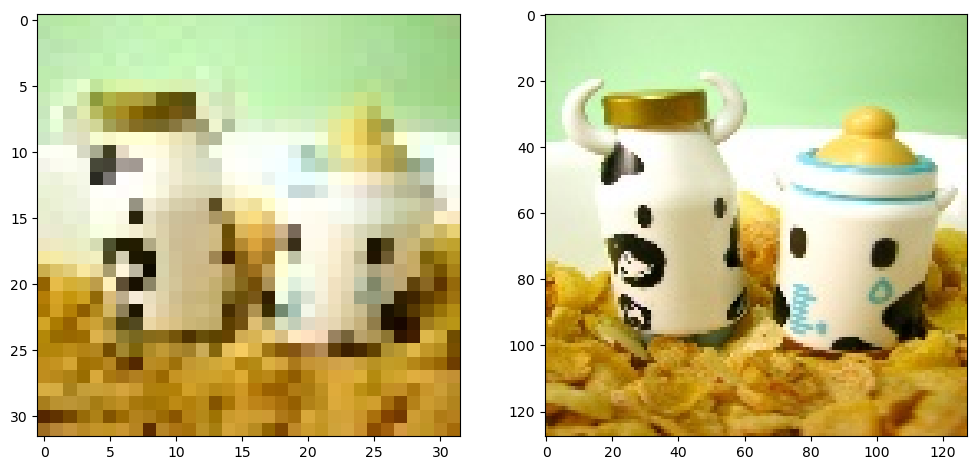

In [13]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=100
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()


In [14]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.20, random_state=42)


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_5[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 64)           256       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 add_4 (Add)                 (None, 32, 32, 64)           0         ['add_3[0][0]',               
                                                                     'batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_11

 p_re_lu_10 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_10[0][0]']          
                                                                                                  
 batch_normalization_19 (Ba  (None, 32, 32, 64)           256       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_9 (Add)                 (None, 32, 32, 64)           0         ['add_8[0][0]',               
                                                                     'batch_normalization_19[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_15 (PReLU)          (None, 32, 32, 64)           64        ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 64)           36928     ['p_re_lu_15[0][0]']          
                                                                                                  
 batch_normalization_29 (Ba  (None, 32, 32, 64)           256       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 add_14 (A

                                                                 
 conv2d_42 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 512)       1180160   
                                                                 
 batch_normalization_38 (Ba  (None, 16, 16, 512)       2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_44

In [15]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [16]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 100
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 100 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                           | 1/80 [00:02<03:28,  2.64s/it]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:03<01:53,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:03<01:22,  1.07s/it]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:04<01:07,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:05<00:59,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:05<00:54,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:06<00:51,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:06<00:48,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:07<00:46,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:08<00:44,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:08<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:09<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:10<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:10<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:11<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:11<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:12<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:13<00:38,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:13<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:14<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:15<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:15<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:16<00:35,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 30%|████████████▉                              | 24/80 [00:16<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:17<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:18<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:18<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:19<00:32,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████▌                           | 29/80 [00:20<00:32,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 38%|████████████████▏                          | 30/80 [00:20<00:31,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 39%|████████████████▋                          | 31/80 [00:21<00:31,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:22<00:30,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:22<00:30,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:23<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:24<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:24<00:28,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:25<00:27,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:26<00:27,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:26<00:26,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:27<00:26,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:27<00:25,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:28<00:24,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:29<00:23,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:29<00:23,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:30<00:22,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:31<00:21,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:31<00:21,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:32<00:20,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:33<00:19,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:33<00:19,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 64%|███████████████████████████▍               | 51/80 [00:34<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:35<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:35<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:36<00:16,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:36<00:15,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:37<00:15,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 71%|██████████████████████████████▋            | 57/80 [00:38<00:14,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:38<00:13,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████████████████████████████▋           | 59/80 [00:39<00:13,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 75%|████████████████████████████████▎          | 60/80 [00:40<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:40<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:41<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:41<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:42<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:43<00:09,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:43<00:09,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████       | 67/80 [00:44<00:08,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:45<00:08,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:46<00:07,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:46<00:07,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:47<00:06,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:48<00:05,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:48<00:04,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:49<00:04,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:50<00:03,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:50<00:02,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:51<00:01,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:52<00:01,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:52<00:00,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:53<00:00,  1.50it/s]


epoch: 1 g_loss: 144.4816738128662 d_loss: [11.68740407  0.6375    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:53,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█                                           | 2/80 [00:01<00:52,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:50,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:49,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▊                                        | 7/80 [00:04<00:48,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:47,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:47,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:46,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:45,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:44,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:09<00:43,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:11<00:40,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:12<00:39,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:13<00:38,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:15<00:38,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:37,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:36,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 32%|█████████████▉                             | 26/80 [00:17<00:36,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:18<00:34,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:19<00:33,  1.52it/s]

1/1 [==============================] - 0s 41ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:33,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:20<00:32,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:21<00:31,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:22<00:30,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:24<00:27,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████████████████████▉                      | 39/80 [00:25<00:26,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████████████████████▌                     | 40/80 [00:26<00:26,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 52%|██████████████████████▌                    | 42/80 [00:27<00:24,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:28<00:24,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 56%|████████████████████████▏                  | 45/80 [00:29<00:23,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:30<00:22,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:31<00:20,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:32<00:20,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:33<00:18,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:34<00:18,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:35<00:17,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:36<00:16,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:36<00:15,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:37<00:15,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████████████████████████████▏           | 58/80 [00:38<00:15,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:38<00:14,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:39<00:13,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:40<00:12,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:40<00:12,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:41<00:11,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:42<00:10,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:42<00:10,  1.50it/s]

1/1 [==============================] - 0s 37ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:43<00:09,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:44<00:08,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:44<00:07,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 86%|█████████████████████████████████████      | 69/80 [00:45<00:07,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:46<00:06,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:46<00:05,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:47<00:05,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:48<00:04,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:48<00:03,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:49<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:50<00:02,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:50<00:01,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:51<00:01,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:51<00:00,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:52<00:00,  1.52it/s]


epoch: 2 g_loss: 100.13158438205718 d_loss: [3.77817527 0.6375    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:24,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 56%|████████████████████████▏                  | 45/80 [00:29<00:27,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:25,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:23,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:31<00:22,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:21,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:20,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:33<00:19,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:35<00:17,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:16,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████████████████████████████             | 56/80 [00:36<00:16,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████▋            | 57/80 [00:37<00:15,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:38<00:15,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:38<00:14,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:39<00:13,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 76%|████████████████████████████████▊          | 61/80 [00:40<00:12,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:40<00:11,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:41<00:11,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:42<00:09,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:43<00:09,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:43<00:08,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:44<00:07,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:45<00:07,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:45<00:06,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:46<00:05,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:47<00:05,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:47<00:04,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:48<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:49<00:03,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:49<00:02,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:50<00:01,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:50<00:01,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:51<00:00,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:52<00:00,  1.53it/s]


epoch: 3 g_loss: 85.09504473209381 d_loss: [2.28627342 0.64375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▌                                           | 1/80 [00:00<00:54,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:51,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


  4%|█▋                                          | 3/80 [00:01<00:50,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▊                                        | 7/80 [00:04<00:48,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:47,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:46,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:45,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:09<00:42,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.53it/s]

1/1 [==============================] - 0s 33ms/step


 21%|█████████▏                                 | 17/80 [00:11<00:41,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:40,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:39,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:13<00:38,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:35,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:35,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:18<00:34,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:33,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:20<00:32,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:31,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:22<00:30,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:29,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████▉                       | 37/80 [00:24<00:28,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:25<00:26,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:26<00:26,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:27<00:24,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:28<00:23,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:29<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:31<00:20,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:20,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:20,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 64%|███████████████████████████▍               | 51/80 [00:33<00:19,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:35<00:16,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:16,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████             | 56/80 [00:36<00:16,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:37<00:15,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:14,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:38<00:13,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 75%|████████████████████████████████▎          | 60/80 [00:39<00:13,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:40<00:11,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:41<00:11,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:42<00:10,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:43<00:09,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:43<00:08,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:44<00:07,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:45<00:07,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:45<00:06,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:46<00:05,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:47<00:05,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:47<00:04,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:48<00:03,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:49<00:03,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:49<00:02,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:50<00:01,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:51<00:01,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:51<00:00,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████| 80/80 [00:52<00:00,  1.52it/s]


epoch: 4 g_loss: 89.24235081672668 d_loss: [2.50141231 0.64375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▌                                           | 1/80 [00:00<00:53,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:51,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:50,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:09<00:42,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:41,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:40,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:39,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:35,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████                            | 28/80 [00:18<00:33,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:33,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:20<00:31,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:25<00:26,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:20,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:15,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:14,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:09,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:43<00:08,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:44<00:07,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:45<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:46<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:48<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:50<00:01,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


epoch: 5 g_loss: 81.53914606571198 d_loss: [1.92563938 0.65625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:11,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 6 g_loss: 79.9476583957672 d_loss: [1.34711915 0.725     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:09,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 7 g_loss: 78.7543224811554 d_loss: [1.92360332 0.66875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:09,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 8 g_loss: 96.44171743392944 d_loss: [2.60202857 0.65625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:22,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:20,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████      | 69/80 [00:44<00:07,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:46<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


epoch: 9 g_loss: 123.03376498222352 d_loss: [1.46841994 0.79375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 10 g_loss: 16228.721723127364 d_loss: [1.28544705 0.74375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:51,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:17,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:16,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:36<00:16,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:15,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:14,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:38<00:13,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:13,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:40<00:11,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:11,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:42<00:09,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:09,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:43<00:08,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:44<00:07,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:45<00:06,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:06,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:46<00:05,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:47<00:04,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:48<00:04,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:48<00:03,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:49<00:02,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:50<00:01,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:51<00:00,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.54it/s]


epoch: 11 g_loss: 6668.809140300751 d_loss: [0.40484688 0.90625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:51,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:51,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


  4%|█▋                                          | 3/80 [00:01<00:50,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:49,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:47,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████▍                                       | 8/80 [00:05<00:47,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:46,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████▍                                     | 10/80 [00:06<00:46,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:45,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 15%|██████▍                                    | 12/80 [00:07<00:45,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:44,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:09<00:43,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:42,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:11<00:41,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:40,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:12<00:39,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:13<00:38,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 29%|████████████▎                              | 23/80 [00:15<00:36,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:35,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:35,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:18<00:34,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:33,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:20<00:31,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:22<00:29,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:24<00:27,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████████████████████▉                      | 39/80 [00:25<00:26,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████▌                     | 40/80 [00:26<00:25,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:27<00:24,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:29<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:31<00:20,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 64%|███████████████████████████▍               | 51/80 [00:33<00:18,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:16,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:36<00:15,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:14,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:38<00:13,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:13,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:40<00:11,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:11,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:42<00:09,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:43<00:08,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:44<00:07,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████      | 69/80 [00:44<00:07,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:45<00:06,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:46<00:05,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:46<00:05,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:47<00:04,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:48<00:03,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:48<00:03,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:49<00:02,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:50<00:02,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:50<00:01,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:51<00:00,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


100%|███████████████████████████████████████████| 80/80 [00:52<00:00,  1.53it/s]


epoch: 12 g_loss: 235.4705841064453 d_loss: [0.42875789 0.94375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:53,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█                                           | 2/80 [00:01<00:52,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


  4%|█▋                                          | 3/80 [00:02<00:52,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:51,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:49,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:04<00:49,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:47,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:48,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:06<00:51,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████▍                                     | 10/80 [00:07<00:53,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█████▉                                     | 11/80 [00:07<00:52,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


 15%|██████▍                                    | 12/80 [00:08<00:50,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:09<00:48,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


 18%|███████▌                                   | 14/80 [00:09<00:47,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


 19%|████████                                   | 15/80 [00:10<00:46,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████▌                                  | 16/80 [00:11<00:45,  1.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:12<00:44,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:12<00:43,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████▏                                | 19/80 [00:13<00:42,  1.43it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██████████▊                                | 20/80 [00:14<00:41,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:14<00:40,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:15<00:39,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:16<00:38,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████▉                              | 24/80 [00:16<00:37,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 31%|█████████████▍                             | 25/80 [00:17<00:37,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████▉                             | 26/80 [00:18<00:37,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████▌                            | 27/80 [00:18<00:36,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:19<00:35,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:20<00:34,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 38%|████████████████▏                          | 30/80 [00:20<00:33,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:21<00:33,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:22<00:32,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:22<00:31,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 42%|██████████████████▎                        | 34/80 [00:23<00:30,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:24<00:29,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 45%|███████████████████▎                       | 36/80 [00:24<00:28,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:25<00:28,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████▍                      | 38/80 [00:26<00:28,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████████████████████▉                      | 39/80 [00:26<00:27,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████████████████████▌                     | 40/80 [00:27<00:27,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


 51%|██████████████████████                     | 41/80 [00:28<00:26,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████▌                    | 42/80 [00:28<00:25,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 54%|███████████████████████                    | 43/80 [00:29<00:25,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:30<00:24,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:30<00:23,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:31<00:22,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:32<00:21,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:32<00:20,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:33<00:20,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:34<00:19,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:34<00:18,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:35<00:17,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 66%|████████████████████████████▍              | 53/80 [00:36<00:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:36<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:37<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:37<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:38<00:14,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:39<00:14,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:39<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:40<00:12,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:41<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:41<00:11,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:42<00:10,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:43<00:10,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:43<00:09,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:44<00:08,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████       | 67/80 [00:44<00:08,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:45<00:07,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:46<00:07,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:46<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:47<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:48<00:05,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:48<00:04,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:49<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:50<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:50<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:51<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:51<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:52<00:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:53<00:00,  1.51it/s]


epoch: 13 g_loss: 163.63114233016967 d_loss: [0.23151623 0.95625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:28,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 14 g_loss: 152.48809728622436 d_loss: [0.00616596 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 15 g_loss: 149.57729716300963 d_loss: [1.49632571e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████▌                                  | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 16 g_loss: 143.57584500312805 d_loss: [7.1090445e-06 1.0000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 17 g_loss: 139.68546719551085 d_loss: [0.34351545 0.96875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▌                                           | 1/80 [00:00<00:56,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:53,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:02<00:50,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 10%|████▍                                       | 8/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:28,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 76%|████████████████████████████████▊          | 61/80 [00:37<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:06,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:45<00:03,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 18 g_loss: 142.99996213912965 d_loss: [0.70476343 0.95      ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:46,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:22<00:26,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:32<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:12,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:37<00:11,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:40<00:08,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:07,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:43<00:05,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:45<00:03,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:48<00:00,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.62it/s]


epoch: 19 g_loss: 138.23890070915223 d_loss: [0.54715975 0.975     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:34,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 24ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:06,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 20 g_loss: 140.68297028541565 d_loss: [8.52123584e-12 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:43,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 21 g_loss: 134.00735306739807 d_loss: [1.02253318e-11 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████▌                                  | 16/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:28,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:22<00:26,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████████████████████████▉                | 50/80 [00:30<00:18,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:32<00:16,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:35<00:13,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:37<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:38<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:40<00:08,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:07,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:45<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 22 g_loss: 144.8877338886261 d_loss: [0.81112652 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:44,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:39,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:33,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:17<00:31,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:28,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:20<00:27,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:26,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:22<00:26,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:23,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:25<00:23,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:30<00:18,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:32<00:16,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:33<00:15,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████████████████████████████▏           | 58/80 [00:35<00:13,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:12,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:36<00:12,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:37<00:11,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:38<00:10,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:40<00:08,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:41<00:07,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:06,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:43<00:05,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:44<00:04,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:45<00:03,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.65it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:46<00:02,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:47<00:01,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:48<00:00,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.63it/s]


epoch: 23 g_loss: 135.78543558120728 d_loss: [0.44053238 0.96875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:12<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:35,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:34,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 24 g_loss: 132.66130957603454 d_loss: [8.50142974e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


  4%|█▋                                          | 3/80 [00:01<00:46,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:45,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:44,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:44,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:43,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:42,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:07<00:41,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:12<00:36,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:33,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 32%|█████████████▉                             | 26/80 [00:15<00:32,  1.64it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:31,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:17<00:31,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:32,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:22<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:25<00:23,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:30<00:18,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 66%|████████████████████████████▍              | 53/80 [00:32<00:16,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:35<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:37<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:40<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 86%|█████████████████████████████████████      | 69/80 [00:42<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:43<00:05,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:45<00:03,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:47<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.61it/s]


epoch: 25 g_loss: 119.88906035423278 d_loss: [5.31584986e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:30,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 26 g_loss: 121.39531660079956 d_loss: [0.00483488 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:51,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:28,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:16,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 27 g_loss: 114.33280429840087 d_loss: [1.1886446 0.95625  ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:28,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 28 g_loss: 109.33822288513184 d_loss: [3.12178078 0.9375    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:27,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:26,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:22,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.57it/s]


epoch: 29 g_loss: 107.04736719131469 d_loss: [4.75483047 0.94375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 30 g_loss: 102.31665430068969 d_loss: [1.58636676 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:22,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 31 g_loss: 101.12981333732606 d_loss: [7.18598715 0.825     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:20,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:19,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 32 g_loss: 108.37357003688813 d_loss: [4.13859677 0.85      ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:07,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 33 g_loss: 96.61585435867309 d_loss: [1.22252901 0.925     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████▎                               | 21/80 [00:13<00:39,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:38,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:37,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:18,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:17,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 34 g_loss: 91.3605481147766 d_loss: [0.43656433 0.95625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:15,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 35 g_loss: 90.30691199302673 d_loss: [0.22515299 0.95625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:15,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 36 g_loss: 92.75597670078278 d_loss: [0.09173202 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 37 g_loss: 89.44495890140533 d_loss: [0.09506357 0.9875    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:48,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:45,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:44,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:09<00:43,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:32,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:32,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:31,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:25<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:26,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:27<00:24,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:23,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:21,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:20,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:32<00:19,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:34<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:39<00:12,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:41<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████      | 69/80 [00:44<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:46<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:51<00:00,  1.56it/s]


epoch: 38 g_loss: 88.34797551631928 d_loss: [0.55256993 0.9375    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:51,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.56it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:20,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:19,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:18,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 39 g_loss: 84.46499176025391 d_loss: [0.77058238 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 40 g_loss: 84.06799750328064 d_loss: [0.00983687 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 41 g_loss: 83.2977748632431 d_loss: [2.4645358e-06 1.0000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:16,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:15,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 42 g_loss: 77.26970386505127 d_loss: [2.37541416e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 24ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 43 g_loss: 80.17579576969146 d_loss: [8.54503573e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:11,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 44 g_loss: 78.95067076683044 d_loss: [9.3714467e-04 1.0000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:09,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 45 g_loss: 75.12929363250733 d_loss: [0.4425298 0.975    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 46 g_loss: 75.87088737487792 d_loss: [1.77220242 0.86875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 47 g_loss: 75.62806785106659 d_loss: [2.19003618 0.8625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 48 g_loss: 76.36446862220764 d_loss: [2.49844786 0.83125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:17,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:12,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 49 g_loss: 74.84059700965881 d_loss: [1.47183284 0.8875    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:39,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:38,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:37,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 50 g_loss: 73.84882678985596 d_loss: [0.36717883 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▌                                           | 1/80 [00:00<00:56,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:52,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:50,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 51 g_loss: 72.77115433216095 d_loss: [0.32415736 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:54,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█                                           | 2/80 [00:01<00:54,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:02<00:52,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:51,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:49,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 52 g_loss: 75.7494196653366 d_loss: [0.60709407 0.96875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:51,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:50,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:49,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:47,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 53 g_loss: 74.18256292343139 d_loss: [0.14525804 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


  8%|███▎                                        | 6/80 [00:03<00:49,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:48,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:47,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:46,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 54 g_loss: 75.07853724956513 d_loss: [1.0082267 0.9125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:47,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:46,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 55 g_loss: 72.87811071872711 d_loss: [0.24260624 0.975     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:45,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 15%|██████▍                                    | 12/80 [00:07<00:44,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 56 g_loss: 72.04223470687866 d_loss: [0.03125324 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:43,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:12,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 57 g_loss: 70.15597443580627 d_loss: [0.02085978 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:41,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:40,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:12<00:40,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:39,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 58 g_loss: 70.2756502866745 d_loss: [1.32896409e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:41,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:40,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:40,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:14<00:38,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:37,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:35,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:29,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:21,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 59 g_loss: 68.68187005519867 d_loss: [9.70039046e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


 28%|███████████▊                               | 22/80 [00:14<00:38,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:37,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 60 g_loss: 69.55653814077377 d_loss: [7.55142769e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:35,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 61 g_loss: 70.23875412940978 d_loss: [6.11432562e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:35,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:34,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:33,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 62 g_loss: 69.35866496562957 d_loss: [5.08110581e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████                            | 28/80 [00:17<00:34,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:33,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 24ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 63 g_loss: 68.54987705945969 d_loss: [4.29797994e-06 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:33,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:32,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 64 g_loss: 69.02637979984283 d_loss: [0.91758939 0.95      ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:51,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:50,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:31,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:30,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 65 g_loss: 67.94884084463119 d_loss: [2.64083517 0.90625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:32,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:28,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:28,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.57it/s]


epoch: 66 g_loss: 66.97281050682068 d_loss: [3.51855827 0.84375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:49,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:48,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:37,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:16<00:35,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:29,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:23<00:29,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 67 g_loss: 66.85029964447021 d_loss: [2.61259672 0.79375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:44,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:27,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:27,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:26,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 68 g_loss: 67.63820033073425 d_loss: [0.31307944 0.95625   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:25,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 69 g_loss: 66.34285871982574 d_loss: [0.06361111 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:22,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 70 g_loss: 65.89872896671295 d_loss: [0.25398312 0.96875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:20,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 71 g_loss: 64.82142260074616 d_loss: [0.03286291 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:20,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 72 g_loss: 65.35048537254333 d_loss: [0.15039922 0.975     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:12<00:36,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:17<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:22<00:26,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:27<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 73 g_loss: 66.98221578598023 d_loss: [0.01708755 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 74 g_loss: 66.5073353767395 d_loss: [0.0025523 1.       ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:28,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:25,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:15,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 46ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 75 g_loss: 65.52046160697937 d_loss: [0.01623097 0.9875    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:13,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 76 g_loss: 71.49861314296723 d_loss: [0.50210431 0.9625    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:09,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 77 g_loss: 64.81221926212311 d_loss: [1.15770484 0.925     ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 78 g_loss: 64.44906136989593 d_loss: [0.25250405 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 79 g_loss: 63.088349199295045 d_loss: [5.78880426e-04 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 80 g_loss: 62.98758165836334 d_loss: [9.13827407e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 32ms/step


  4%|█▋                                          | 3/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 81 g_loss: 64.45629088878631 d_loss: [0.00297929 1.        ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 82 g_loss: 67.35884940624237 d_loss: [0.76203009 0.93125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:30,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 83 g_loss: 64.11723685264587 d_loss: [0.99656826 0.9       ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:51,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:50,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


  6%|██▊                                         | 5/80 [00:03<00:49,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:09,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 84 g_loss: 62.9794284582138 d_loss: [1.67005016 0.85      ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:47,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▊                                        | 7/80 [00:04<00:47,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:05<00:46,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█████▉                                     | 11/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:34,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:26,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:25,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:16,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 85 g_loss: 62.49436305761337 d_loss: [0.49950597 0.94375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 10%|████▍                                       | 8/80 [00:05<00:47,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:47,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:07<00:44,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 86 g_loss: 63.67257091999054 d_loss: [0.21803546 0.98125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█████▉                                     | 11/80 [00:06<00:45,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:44,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:14,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 87 g_loss: 63.317449355125426 d_loss: [0.00392872 1.        ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 16%|██████▉                                    | 13/80 [00:08<00:43,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 18%|███████▌                                   | 14/80 [00:08<00:43,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:41,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 88 g_loss: 63.78783566951752 d_loss: [0.00952146 0.99375   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:42,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:42,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:12<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 89 g_loss: 61.9319442152977 d_loss: [1.05860173e-04 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:41,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:40,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:12<00:39,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.58it/s]

1/1 [==============================] - 0s 47ms/step


 30%|████████████▉                              | 24/80 [00:15<00:36,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:26<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 90 g_loss: 61.65358283519745 d_loss: [7.15593327e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:38,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:37,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:36,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.60it/s]


epoch: 91 g_loss: 61.536881709098814 d_loss: [4.18323329e-04 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:35,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:35,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:34,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:33,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:27,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:24,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:22,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:20,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:09,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.60it/s]


epoch: 92 g_loss: 62.51763380765915 d_loss: [4.59239576e-05 1.00000000e+00]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:47,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.64it/s]

1/1 [==============================] - 0s 26ms/step


  5%|██▏                                         | 4/80 [00:02<00:46,  1.63it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:38,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:12<00:36,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:35,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:32,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:30,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:29<00:19,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:34<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:41<00:08,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:44<00:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:49<00:00,  1.60it/s]


epoch: 93 g_loss: 75.84398115873337 d_loss: [0.96867568 0.8875    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:40,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:38,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████▉                              | 24/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:30,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:30,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:29,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 64%|███████████████████████████▍               | 51/80 [00:31<00:18,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 94 g_loss: 65.31513087749481 d_loss: [1.31664159 0.86875   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:28,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:28,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:27,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:19,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:09,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 95 g_loss: 67.56570172309875 d_loss: [0.82448247 0.93125   ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:48,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███▊                                        | 7/80 [00:04<00:46,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:27,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:38<00:11,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:43<00:06,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:48<00:01,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 96 g_loss: 63.15413806438446 d_loss: [0.22501143 0.95      ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 11%|████▉                                       | 9/80 [00:05<00:43,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:42,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 16%|██████▉                                    | 13/80 [00:08<00:41,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|████████                                   | 15/80 [00:09<00:40,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:09<00:39,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:38,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:37,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████▎                               | 21/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:14<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:19<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.61it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:26,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████████████████████▌                     | 40/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 67ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:27,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:26,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:45<00:04,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 97 g_loss: 61.622251224517825 d_loss: [0.0052901 1.       ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                           | 1/80 [00:00<00:50,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:49,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████▍                                     | 10/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:42,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


 18%|███████▌                                   | 14/80 [00:08<00:42,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:40,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:34,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:32,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:31,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:24<00:26,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.59it/s]

1/1 [==============================] - 0s 66ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:24,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:22,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████████████████████████▎                | 49/80 [00:31<00:19,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:15,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:36<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:38<00:12,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:43<00:07,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:06,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:50<00:00,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]


epoch: 98 g_loss: 62.605830538272855 d_loss: [0.04852616 0.9875    ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▌                                           | 1/80 [00:00<00:48,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


  4%|█▋                                          | 3/80 [00:01<00:47,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████▍                                       | 8/80 [00:04<00:44,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|████████████▉                              | 24/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:29,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 44%|██████████████████▊                        | 35/80 [00:21<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:27,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:24,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:23,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:22,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 57%|████████████████████████▋                  | 46/80 [00:29<00:22,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:20,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:19,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:18,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:17,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:12,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:40<00:09,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:47<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.59it/s]


epoch: 99 g_loss: 61.240471160411836 d_loss: [0.00102801 1.        ]


  0%|                                                    | 0/80 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                           | 1/80 [00:00<00:49,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█                                           | 2/80 [00:01<00:48,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  4%|█▋                                          | 3/80 [00:01<00:48,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


  5%|██▏                                         | 4/80 [00:02<00:47,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


  6%|██▊                                         | 5/80 [00:03<00:47,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|███▎                                        | 6/80 [00:03<00:46,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███▊                                        | 7/80 [00:04<00:45,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|████▍                                       | 8/80 [00:05<00:45,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████▉                                       | 9/80 [00:05<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████▍                                     | 10/80 [00:06<00:44,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█████▉                                     | 11/80 [00:06<00:43,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 15%|██████▍                                    | 12/80 [00:07<00:43,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 16%|██████▉                                    | 13/80 [00:08<00:42,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▌                                   | 14/80 [00:08<00:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 19%|████████                                   | 15/80 [00:09<00:41,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|████████▌                                  | 16/80 [00:10<00:40,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 21%|█████████▏                                 | 17/80 [00:10<00:39,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 22%|█████████▋                                 | 18/80 [00:11<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████▏                                | 19/80 [00:11<00:38,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████▊                                | 20/80 [00:12<00:37,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 26%|███████████▎                               | 21/80 [00:13<00:37,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▊                               | 22/80 [00:13<00:36,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 29%|████████████▎                              | 23/80 [00:14<00:35,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 30%|████████████▉                              | 24/80 [00:15<00:35,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 31%|█████████████▍                             | 25/80 [00:15<00:34,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 32%|█████████████▉                             | 26/80 [00:16<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 34%|██████████████▌                            | 27/80 [00:17<00:33,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███████████████                            | 28/80 [00:17<00:32,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████▌                           | 29/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 38%|████████████████▏                          | 30/80 [00:18<00:31,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 39%|████████████████▋                          | 31/80 [00:19<00:30,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|█████████████████▏                         | 32/80 [00:20<00:30,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|█████████████████▋                         | 33/80 [00:20<00:29,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 42%|██████████████████▎                        | 34/80 [00:21<00:28,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 44%|██████████████████▊                        | 35/80 [00:22<00:28,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 45%|███████████████████▎                       | 36/80 [00:22<00:27,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 46%|███████████████████▉                       | 37/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████████████████████▍                      | 38/80 [00:23<00:26,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████████████████████▉                      | 39/80 [00:24<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████████████████████▌                     | 40/80 [00:25<00:25,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 51%|██████████████████████                     | 41/80 [00:25<00:24,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 52%|██████████████████████▌                    | 42/80 [00:26<00:23,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 54%|███████████████████████                    | 43/80 [00:27<00:23,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████▋                   | 44/80 [00:27<00:22,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████▏                  | 45/80 [00:28<00:21,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████▋                  | 46/80 [00:28<00:21,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████▎                 | 47/80 [00:29<00:21,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████████████████████████▊                 | 48/80 [00:30<00:21,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████▎                | 49/80 [00:30<00:20,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████████████████████████▉                | 50/80 [00:31<00:19,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 64%|███████████████████████████▍               | 51/80 [00:32<00:18,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████▉               | 52/80 [00:32<00:18,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 66%|████████████████████████████▍              | 53/80 [00:33<00:17,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████              | 54/80 [00:34<00:16,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████▌             | 55/80 [00:34<00:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████             | 56/80 [00:35<00:14,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████▋            | 57/80 [00:35<00:14,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████▏           | 58/80 [00:36<00:13,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████████████████████████████▋           | 59/80 [00:37<00:13,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 75%|████████████████████████████████▎          | 60/80 [00:37<00:12,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 76%|████████████████████████████████▊          | 61/80 [00:38<00:11,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████▎         | 62/80 [00:39<00:11,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████▊         | 63/80 [00:39<00:10,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████▍        | 64/80 [00:40<00:10,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████▉        | 65/80 [00:41<00:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████▍       | 66/80 [00:41<00:08,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████████████████████████████████       | 67/80 [00:42<00:08,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████▌      | 68/80 [00:42<00:07,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████      | 69/80 [00:43<00:07,  1.57it/s]

1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████▋     | 70/80 [00:44<00:06,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|██████████████████████████████████████▏    | 71/80 [00:44<00:05,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 90%|██████████████████████████████████████▋    | 72/80 [00:45<00:05,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████▏   | 73/80 [00:46<00:04,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████▊   | 74/80 [00:46<00:03,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████▎  | 75/80 [00:47<00:03,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████▊  | 76/80 [00:48<00:02,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████████████████████████████████████▍ | 77/80 [00:48<00:01,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████████████████████████████████████▉ | 78/80 [00:49<00:01,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████████▍| 79/80 [00:49<00:00,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████████| 80/80 [00:50<00:00,  1.58it/s]

epoch: 100 g_loss: 63.263464784622194 d_loss: [0.14562534 0.99375   ]



/Users/rohitkumar/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_20.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)
# try to save generated images in a particular location-------remember this

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 0s 359ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
